In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import warnings
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates

In [ ]:
file_path = '../sample_lottery_data.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

plt.rcParams['font.sans-serif'] = ['Source Han Sans SC']
plt.rcParams['axes.unicode_minus'] = False

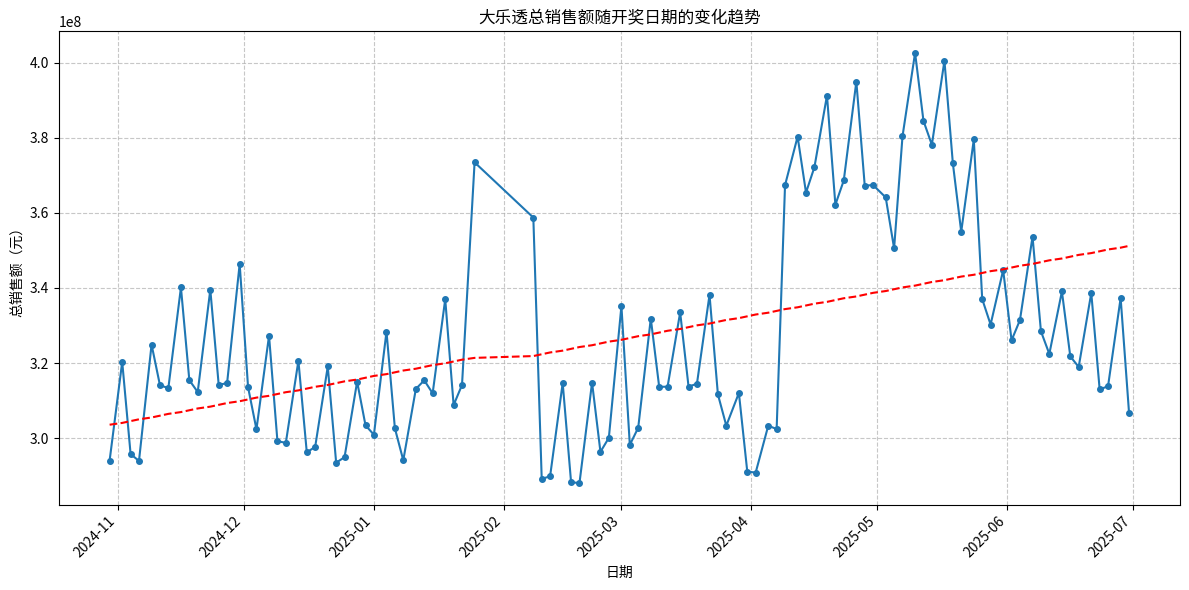

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['total_sales'], 'o-', markersize=4, label='总销售额')

x = np.arange(len(data))
z = np.polyfit(x, data['total_sales'], 1)
p = np.poly1d(z)
plt.plot(data['date'], p(x), 'r--', label='趋势线')

plt.title('大乐透总销售额随开奖日期的变化趋势')
plt.xlabel('日期')
plt.ylabel('总销售额（元）')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('./sales_trend.png')
plt.show()
plt.close()

In [4]:
last_date = data['date'].max()
next_date = last_date + timedelta(2)

ts_data = data.set_index('date')['total_sales']
ts_data -= 2.8e8

ts_data = pd.Series(ts_data.values, index=pd.DatetimeIndex(ts_data.index))

# 定义函数检查序列是否平稳
def adf_test(seq):
    res = adfuller(seq, autolag='AIC')
    return res[1] < 0.05

# 确定非季节性部分最优差分阶数d
def findd(seq, maxd=5):
    d = 0
    nseq = seq.copy()

    res = adf_test(nseq)

    while not res and d < maxd:
        d += 1
        nseq = nseq.diff().dropna()
        res = adf_test(nseq)

    return d

d = findd(ts_data)
# print(f"选择的最优非季节性部分差分阶数d: {d}")

# 确定季节性部分最优差分阶数d
def findD(seq, s=7, maxD=5):
    D = 0
    nseq = seq.copy()

    acf_values = pd.Series(tsaplots.acf(nseq, nlags=s*3))

    seasonal_corr = np.mean([abs(acf_values[s]), abs(acf_values[2*s])])

    while seasonal_corr > 0.2 and D < maxD:
        D += 1
        nseq = nseq.diff(s).dropna()

        if len(nseq) > s*3:
            acf_values = pd.Series(tsaplots.acf(nseq, nlags=s*3))
            seasonal_corr = np.mean([abs(acf_values[s]), abs(acf_values[2*s])])

    return D

D = findD(ts_data)
# print(f"选择的最优季节性差分阶数D: {D}")

# 使用AIC网格搜索法确定p、q、P、Q的最佳参数
def sarima_grid_search(ts_data, d, D, s=7, maxp=5, maxq=5, maxP=5, maxQ=5):
    best_aic = float('inf')
    best_params = None

    warnings.filterwarnings("ignore")

    for p in range(maxp + 1):
        for q in range(maxq + 1):
            for P in range(maxP + 1):
                for Q in range(maxQ + 1):
                    if p == 0 and q == 0 and P == 0 and Q == 0:
                        continue

                    try:
                        model = SARIMAX(ts_data,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

                        model_fit = model.fit(disp=False)
                        aic = model_fit.aic

                        print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - AIC: {aic}")

                        if aic < best_aic:
                            best_aic = aic
                            best_params = (p, d, q, P, D, Q, s)

                    except:
                        continue

    print(f"best_params\n: SARIMA{best_params[:3]}x{best_params[3:]} - AIC: {best_aic}")
    return best_params

best_params = sarima_grid_search(ts_data, d, D)
p, d, q, P, D, Q, s = best_params

model = SARIMAX(ts_data,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s)
               )

model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=1)

predicted_sales = forecast.iloc[0] + 2.8e8
ts_data += 2.8e8

print(f"Predict the sales of {next_date.strftime('%Y-%m-%d')} is {predicted_sales:.2f} Yuan")

SARIMA(0,1,0)x(0,1,1,7) - AIC: 3108.656613334871
SARIMA(0,1,0)x(0,1,2,7) - AIC: 2850.4714773183136
SARIMA(0,1,0)x(0,1,3,7) - AIC: 2591.5562073449796
SARIMA(0,1,0)x(0,1,4,7) - AIC: 6345.261856400818
SARIMA(0,1,0)x(0,1,5,7) - AIC: 2078.7124263201795
SARIMA(0,1,0)x(1,1,0,7) - AIC: 3183.460503627306
SARIMA(0,1,0)x(1,1,1,7) - AIC: 3105.2985833772454
SARIMA(0,1,0)x(1,1,2,7) - AIC: 2840.949543379112
SARIMA(0,1,0)x(1,1,3,7) - AIC: 2587.999192804978
SARIMA(0,1,0)x(1,1,4,7) - AIC: 6249.95416092666
SARIMA(0,1,0)x(1,1,5,7) - AIC: 2080.146138079777
SARIMA(0,1,0)x(2,1,0,7) - AIC: 2871.4070538085557
SARIMA(0,1,0)x(2,1,1,7) - AIC: 2858.755918395271
SARIMA(0,1,0)x(2,1,2,7) - AIC: 2819.6126399029486
SARIMA(0,1,0)x(2,1,3,7) - AIC: 2552.399005345171
SARIMA(0,1,0)x(2,1,4,7) - AIC: 6156.581649414654
SARIMA(0,1,0)x(2,1,5,7) - AIC: 2074.69835655695
SARIMA(0,1,0)x(3,1,0,7) - AIC: 2612.602149510862
SARIMA(0,1,0)x(3,1,1,7) - AIC: 2612.868617659947
SARIMA(0,1,0)x(3,1,2,7) - AIC: 2613.807799762681
SARIMA(0,1,0)x(3

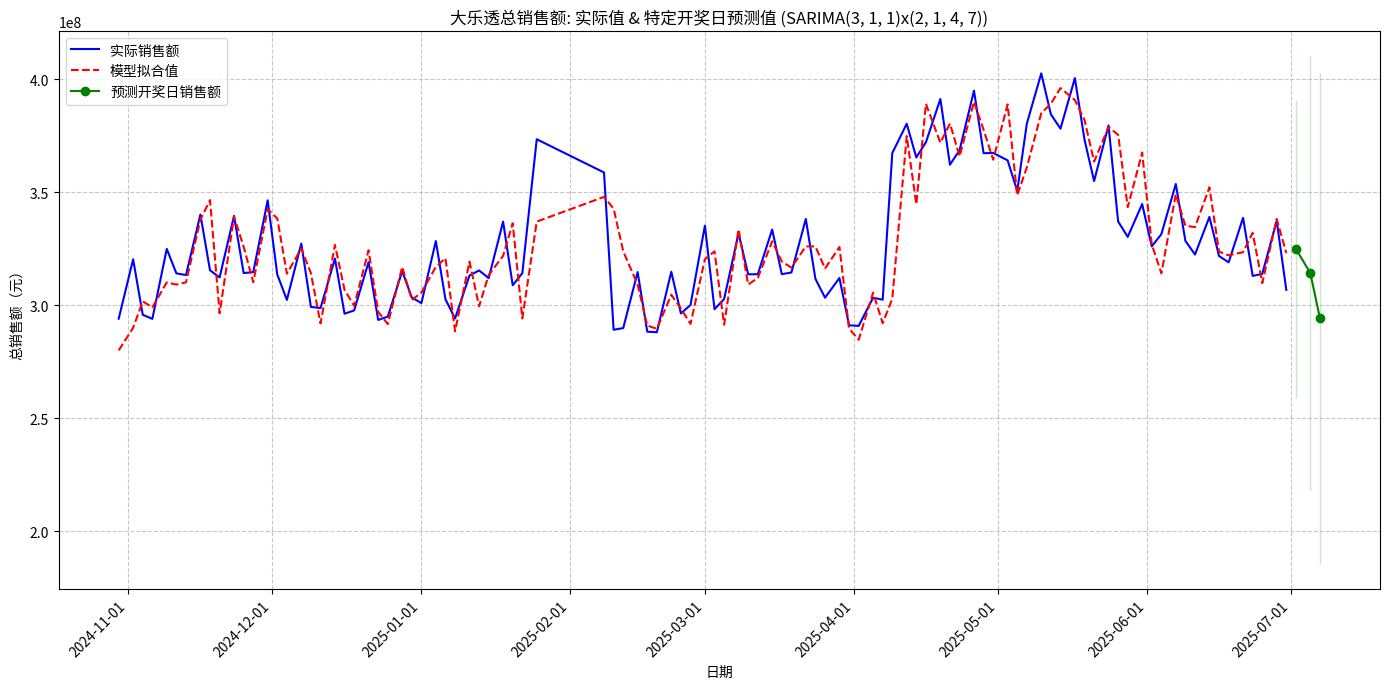

Predict the next three sales of lottery in the future:
Date 2025-07-02: 324898795.23 Yuan (95% CI: [258786751.64, 391010838.81])
Date 2025-07-05: 314213116.96 Yuan (95% CI: [218245315.73, 410180918.19])
Date 2025-07-07: 294178950.89 Yuan (95% CI: [185518412.04, 402839489.74])


In [5]:
fitted_values = model_fit.fittedvalues + 2.8e8

last_date = ts_data.index[-1]

forecast_dates = [
    last_date + pd.Timedelta(days=2),
    last_date + pd.Timedelta(days=5),
    last_date + pd.Timedelta(days=7)
]

forecast_steps = 7
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)

continuous_forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

forecast_values = []
forecast_lower = []
forecast_upper = []
for date in forecast_dates:
    days_ahead = (date - last_date).days - 1
    if 0 <= days_ahead < len(forecast_mean):
        forecast_values.append(forecast_mean.iloc[days_ahead] + 2.8e8)
        forecast_lower.append(forecast_ci.iloc[days_ahead, 0] + 2.8e8)
        forecast_upper.append(forecast_ci.iloc[days_ahead, 1] + 2.8e8)

plt.figure(figsize=(14, 7))

plt.plot(ts_data.index, ts_data.values, 'b-', label='实际销售额')

plt.plot(fitted_values.index, fitted_values.values, 'r--', label='模型拟合值')

plt.plot(forecast_dates, forecast_values, 'g-o', markersize=6, label='预测开奖日销售额')

for i in range(len(forecast_dates)):
    plt.fill_between([forecast_dates[i]], [forecast_lower[i]], [forecast_upper[i]],
                     color='g', alpha=0.2)

plt.title(f'大乐透总销售额: 实际值 & 特定开奖日预测值 (SARIMA{(p,d,q)}x{(P,D,Q,s)})')
plt.xlabel('日期')
plt.ylabel('总销售额（元）')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.savefig('./sales_prediction_lottery_days.png')
plt.show()

print(f"Predict the next three sales of lottery in the future:")
for i, (date, mean, lower, upper) in enumerate(zip(forecast_dates, forecast_values, forecast_lower, forecast_upper)):
    print(f"Date {date.strftime('%Y-%m-%d')}: {mean:.2f} Yuan (95% CI: [{lower:.2f}, {upper:.2f}])")